### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networks_cifar as networks 
import utils
    
%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 1        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

### Load dataset

In [19]:
import torchvision
import torchvision.transforms as transforms

cifar_image_shape = (32, 32, 3)
random_pad_size = 2
# Training images augmented by randomly shifting images by at max. 2 pixels in any of 4 directions
transform_train = transforms.Compose(
                [
                    transforms.RandomCrop(cifar_image_shape[ :-1], random_pad_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )

train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR_dataset/', train=True, 
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR_dataset/', train=False, 
                                            download=True, transform=transform_test)

num_train = int(1.0 * len(train_val_dataset) * 95 / 100)
num_val = len(train_val_dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=128, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
num_class = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dog


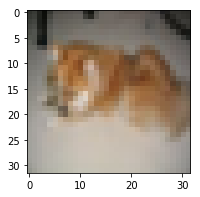

In [6]:
plt.rcParams['figure.figsize'] = [3, 3]
index = 17
plt.imshow((train_dataset[index][0] * 0.5 + 0.5).numpy().transpose(1, 2, 0))
print(classes[train_dataset[index][1]])

### Train teacher network

In [7]:
checkpoints_path = 'CIFAR_checkpoints_teacher/'
if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [15]:
num_epochs = 60
print_every = 100    # Interval size for which to print statistics of training

In [16]:
# Hyperparamters can be tuned by setting required range below
# learning_rates = list(np.logspace(-4, -2, 3))
learning_rates = [1e-2]
learning_rate_decays = [0.95]    # learning rate decays at every epoch
# weight_decays = [0.0] + list(np.logspace(-5, -1, 5))
weight_decays = [1e-5]           # regularization weight
momentums = [0.9]
# dropout_probabilities = [(0.2, 0.5), (0.0, 0.0)]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['dropout_input'] = hparam_tuple[0][0]
    hparam['dropout_hidden'] = hparam_tuple[0][1]
    hparam['weight_decay'] = hparam_tuple[1]
    hparam['lr_decay'] = hparam_tuple[2]
    hparam['momentum'] = hparam_tuple[3]
    hparam['lr'] = hparam_tuple[4]
    hparams_list.append(hparam)

results = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    teacher_net = networks.TeacherNetwork(cifar_image_shape, num_class)
    teacher_net = teacher_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results[hparam_tuple] = utils.trainTeacherOnHparam(teacher_net, hparam, num_epochs, 
                                                        train_loader, val_loader, 
                                                        print_every=print_every, 
                                                        fast_device=fast_device)
    save_path = checkpoints_path + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results[hparam_tuple], 
                'model_state_dict' : teacher_net.state_dict(), 
                'epoch' : num_epochs}, save_path)

Training with hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation loss: 2.305 validation accuracy: 0.096
[1,   100/  372] train loss: 1.881 train accuracy: 0.352
[1,   200/  372] train loss: 1.635 train accuracy: 0.391
[1,   300/  372] train loss: 1.794 train accuracy: 0.438
epoch: 1 validation loss: 1.715 validation accuracy: 0.388
[2,   100/  372] train loss: 1.545 train accuracy: 0.461
[2,   200/  372] train loss: 1.580 train accuracy: 0.422
[2,   300/  372] train loss: 1.622 train accuracy: 0.500
epoch: 2 validation loss: 1.584 validation accuracy: 0.446
[3,   100/  372] train loss: 1.584 train accuracy: 0.477
[3,   200/  372] train loss: 1.486 train accuracy: 0.469
[3,   300/  372] train loss: 1.666 train accuracy: 0.469
epoch: 3 validation loss: 1.520 validation accuracy: 0.477
[4,   100/  372] train loss: 1.327 train accuracy: 0.531
[4,   200/  372] train loss: 1.341 train accuracy: 0.492
[4,   300/  372] tra

[35,   300/  372] train loss: 0.710 train accuracy: 0.758
epoch: 35 validation loss: 1.231 validation accuracy: 0.583
[36,   100/  372] train loss: 0.697 train accuracy: 0.750
[36,   200/  372] train loss: 0.879 train accuracy: 0.641
[36,   300/  372] train loss: 0.883 train accuracy: 0.711
epoch: 36 validation loss: 1.229 validation accuracy: 0.581
[37,   100/  372] train loss: 0.745 train accuracy: 0.750
[37,   200/  372] train loss: 0.834 train accuracy: 0.734
[37,   300/  372] train loss: 0.801 train accuracy: 0.734
epoch: 37 validation loss: 1.201 validation accuracy: 0.590
[38,   100/  372] train loss: 0.772 train accuracy: 0.789
[38,   200/  372] train loss: 0.847 train accuracy: 0.672
[38,   300/  372] train loss: 0.896 train accuracy: 0.719
epoch: 38 validation loss: 1.230 validation accuracy: 0.589
[39,   100/  372] train loss: 0.777 train accuracy: 0.758
[39,   200/  372] train loss: 0.746 train accuracy: 0.758
[39,   300/  372] train loss: 0.693 train accuracy: 0.797
epoch:

In [20]:
# Calculate test accuracy
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

test accuracy:  0.6128


### Hyperparemeter search utils

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['lr']) for h in hparams_list])
dropout_scatter = [int(h['dropout_input'] == 0.2) for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
for hparam in hparams_list:
    load_path = 'checkpoints/' + utils.hparamToString(hparam) + '_final.tar'
    print(utils.hparamToString(hparam))
    load_dict = torch.load(load_path)
    plt.plot(utils.getTrainMetricPerEpoch(load_dict['results']['train_loss'], len(train_loader)))
    plt.show()
    plt.plot(utils.getTrainMetricPerEpoch(load_dict['results']['train_acc'], len(train_loader)))
    plt.show()